In [15]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap



# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16(weights='imagenet', include_top=True)

# load an image
file = shap.datasets.imagenet50(39)
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

#load imagenet image
#X = shap.datasets.imagenet50(39)

# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)

TypeError: expected str, bytes or os.PathLike object, not tuple

In [19]:
print(shap.datasets.imagenet50(39))

(array([[[[ 33.,  23.,  24.],
         [ 72.,  64.,  61.],
         [ 68.,  61.,  53.],
         ...,
         [ 86., 113., 158.],
         [124., 148., 182.],
         [ 41.,  65., 103.]],

        [[ 63.,  51.,  51.],
         [ 23.,  13.,  11.],
         [ 38.,  29.,  22.],
         ...,
         [ 77., 106., 150.],
         [ 94., 123., 163.],
         [ 72.,  95., 137.]],

        [[ 29.,  20.,  13.],
         [ 37.,  28.,  19.],
         [ 64.,  55.,  46.],
         ...,
         [ 83., 110., 153.],
         [ 94., 127., 170.],
         [131., 153., 194.]],

        ...,

        [[ 98., 153., 122.],
         [ 72., 140., 103.],
         [ 49.,  79.,  53.],
         ...,
         [207., 171.,  75.],
         [ 78.,  61.,  15.],
         [ 56.,  96.,  72.]],

        [[ 92., 142., 113.],
         [ 72., 143., 103.],
         [ 53.,  79.,  52.],
         ...,
         [249., 209., 114.],
         [116.,  91.,  35.],
         [ 62.,  96.,  71.]],

        [[ 96., 151., 122.],
      

In [13]:
# segment the image so with don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)

In [14]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(model, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times

Provided model function fails when applied to the provided data set.


ValueError: Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 50)

In [ ]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [10]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

NameError: name 'top_preds' is not defined

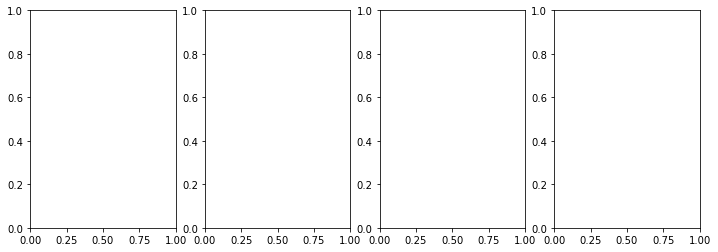

In [11]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()